# Setup

In [101]:
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import laspy
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection
import uuid
import scipy.stats
import seaborn as sns
from sklearn.preprocessing import normalize

# from train_split import TrainSplit

In [102]:
PATH = "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2017_LiDAR/DUC_A01_2017_LAS/FULL/4_first_las_files.las"
# PATH = "C:/Users/joaov/Documents/UFMG/TCC/Dataset/DUC_A01_2017_LiDAR/DUC_A01_2017_LAS/DUCL0001C0004.las"

In [103]:
las = laspy.read(PATH)

In [104]:
lidar_data = np.vstack(
    (
        las.X,
        las.Y,
        las.Z,
        las.intensity,
        las.return_number,
        las.number_of_returns,
        las.classification,
    )
).transpose()

In [105]:
lidar_dataset: pd.DataFrame = pd.DataFrame(
    lidar_data,
    columns=[
        "X",
        "Y",
        "Z",
        "intensity",
        "return_number",
        "number_of_returns",
        "classification",
    ],
)

In [106]:
lidar_dataset["X"] = lidar_dataset["X"] / 100
lidar_dataset["Y"] = lidar_dataset["Y"] / 100
lidar_dataset["Z"] = lidar_dataset["Z"] / 100

In [107]:
del las
del lidar_data

In [108]:
lidar_dataset

,X,Y,Z,intensity,return_number,number_of_returns,classification
0,838257.05,9674657.51,76.59,1,2,2,1
1,838257.11,9674657.22,76.33,1,2,2,1
2,838257.04,9674657.77,77.84,1,2,2,1
3,838257.05,9674657.80,78.24,2,1,1,1
4,838257.08,9674657.67,78.28,1,1,1,1
...,...,...,...,...,...,...,...
64274556,841000.00,9674125.71,116.18,6,1,2,1
64274557,841000.24,9674129.95,107.16,1,2,2,1
64274558,841000.22,9674129.66,107.19,1,2,2,1
64274559,841000.18,9674128.53,104.07,1,2,2,1


# Exploração

In [109]:
lidar_dataset["classification"].unique()

array([1, 2])

In [110]:
lidar_dataset[lidar_dataset["return_number"] == 1]["Z"].describe()

count    4.919999e+07
mean     9.064246e+01
std      1.872428e+01
min      4.077000e+01
25%      7.653000e+01
50%      8.793000e+01
75%      1.016100e+02
max      1.500200e+02
Name: Z, dtype: float64

In [126]:
lidar_dataset[lidar_dataset["return_number"] == 2]["Z"].describe()

count    1.371297e+07
mean     8.319745e+01
std      1.916856e+01
min      4.028000e+01
25%      6.884000e+01
50%      8.053000e+01
75%      9.615000e+01
max      1.457600e+02
Name: Z, dtype: float64

## Cálculo da função de densidade

In [141]:
density = scipy.stats.gaussian_kde(
    lidar_dataset[lidar_dataset["return_number"] == 1]["Z"]
)

In [142]:
x = np.linspace(0, 200, 400)
y = density(x)
data = pd.DataFrame(data=np.vstack([x, y]).transpose(), columns=["X", "Y"])

<Axes: xlabel='X', ylabel='Y'>

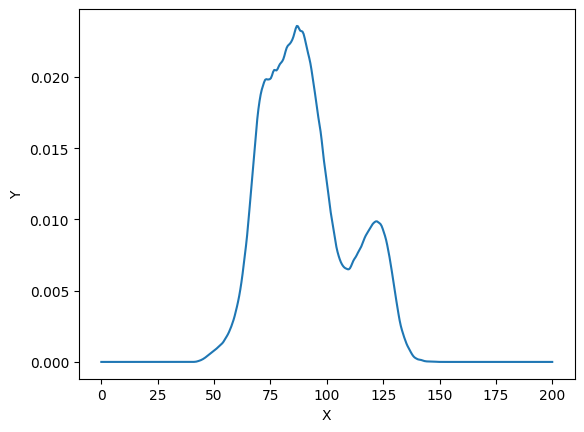

In [143]:
sns.lineplot(data, x="X", y="Y")

In [181]:
bins = 10

<Axes: xlabel='Z', ylabel='Count'>

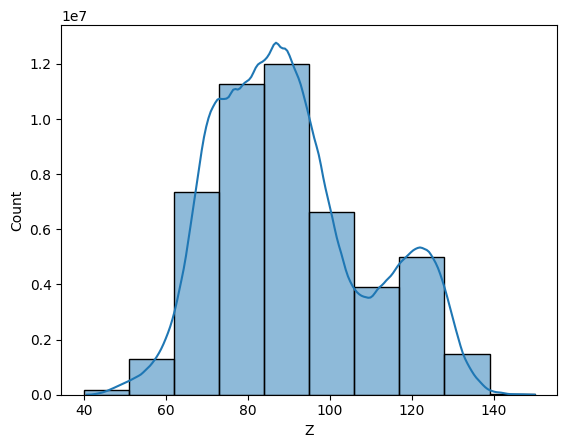

In [182]:
sns.histplot(
    data=lidar_dataset[(lidar_dataset["return_number"] == 1)]["Z"],
    bins=bins,
    kde=True,
    binrange=(40, 150),
)

In [183]:
first_returns_hist, first_returns_bin_edges = np.histogram(
    lidar_dataset[lidar_dataset["return_number"] == 1]["Z"],
    bins=bins,
    density=True,
    range=(40, 150),
)

In [184]:
first_returns_hist, first_returns_bin_edges

(array([3.19225866e-04, 2.40124037e-03, 1.36001915e-02, 2.08559803e-02,
        2.21638520e-02, 1.22730367e-02, 7.24103820e-03, 9.21626592e-03,
        2.75952390e-03, 7.87361595e-05]),
 array([ 40.,  51.,  62.,  73.,  84.,  95., 106., 117., 128., 139., 150.]))

<Axes: xlabel='Z', ylabel='Count'>

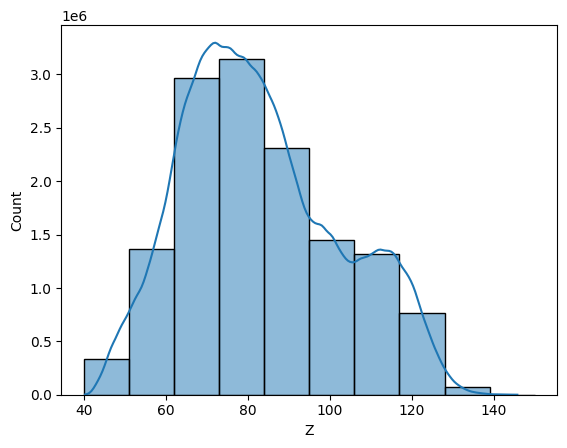

In [185]:
sns.histplot(
    data=lidar_dataset[(lidar_dataset["return_number"] == 2)]["Z"],
    bins=bins,
    kde=True,
    binrange=(40, 150),
)

In [186]:
second_returns_hist, second_returns_bin_edges = np.histogram(
    lidar_dataset[lidar_dataset["return_number"] == 2]["Z"],
    bins=bins,
    density=True,
    range=(40, 150),
)

In [187]:
second_returns_hist, second_returns_bin_edges

(array([2.21932544e-03, 9.02883714e-03, 1.96551001e-02, 2.08412830e-02,
        1.53003512e-02, 9.62386103e-03, 8.71545766e-03, 5.05671203e-03,
        4.58855541e-04, 9.30771046e-06]),
 array([ 40.,  51.,  62.,  73.,  84.,  95., 106., 117., 128., 139., 150.]))

In [188]:
matrix_probability = np.ndarray((bins, bins))

In [189]:
for i in range(0, bins):
    # print(f"Bin - primeiros retornos: {first_returns_bin_edges[i]}")

    for j in range(0, bins):
        # print(f"Bin - segundos retornos: {second_returns_bin_edges[j]}")
        if i == j:
            matrix_probability[i, j] = first_returns_hist[j]
        elif j > i:

            matrix_probability[i, j] = 0
        else:
            _mask_first_returns = (
                (lidar_dataset["return_number"] == 1)
                & (lidar_dataset["number_of_returns"] > 1)
                & (lidar_dataset["Z"] > first_returns_bin_edges[i - 1])
                & (lidar_dataset["Z"] <= first_returns_bin_edges[i])
            )
            _mask_second_returns = (
                (lidar_dataset["return_number"] == 2)
                & (lidar_dataset["number_of_returns"] > 1)
                & (lidar_dataset["Z"] > first_returns_bin_edges[j - 1])
                & (lidar_dataset["Z"] <= first_returns_bin_edges[j])
            )
            print(
                f"Bin - primeiros retornos: {first_returns_bin_edges[i]} - segundos retornos: {second_returns_bin_edges[j]}"
            )
            _count_first_return = lidar_dataset[_mask_first_returns]["Z"].count()
            _count_second_return = lidar_dataset[_mask_second_returns]["Z"].count()
            matrix_probability[i, j] = _count_first_return + _count_second_return

Bin - primeiros retornos: 51.0 - segundos retornos: 40.0
Bin - primeiros retornos: 62.0 - segundos retornos: 40.0
Bin - primeiros retornos: 62.0 - segundos retornos: 51.0
Bin - primeiros retornos: 73.0 - segundos retornos: 40.0
Bin - primeiros retornos: 73.0 - segundos retornos: 51.0
Bin - primeiros retornos: 73.0 - segundos retornos: 62.0
Bin - primeiros retornos: 84.0 - segundos retornos: 40.0
Bin - primeiros retornos: 84.0 - segundos retornos: 51.0
Bin - primeiros retornos: 84.0 - segundos retornos: 62.0
Bin - primeiros retornos: 84.0 - segundos retornos: 73.0
Bin - primeiros retornos: 95.0 - segundos retornos: 40.0
Bin - primeiros retornos: 95.0 - segundos retornos: 51.0
Bin - primeiros retornos: 95.0 - segundos retornos: 62.0
Bin - primeiros retornos: 95.0 - segundos retornos: 73.0
Bin - primeiros retornos: 95.0 - segundos retornos: 84.0
Bin - primeiros retornos: 106.0 - segundos retornos: 40.0
Bin - primeiros retornos: 106.0 - segundos retornos: 51.0
Bin - primeiros retornos: 106

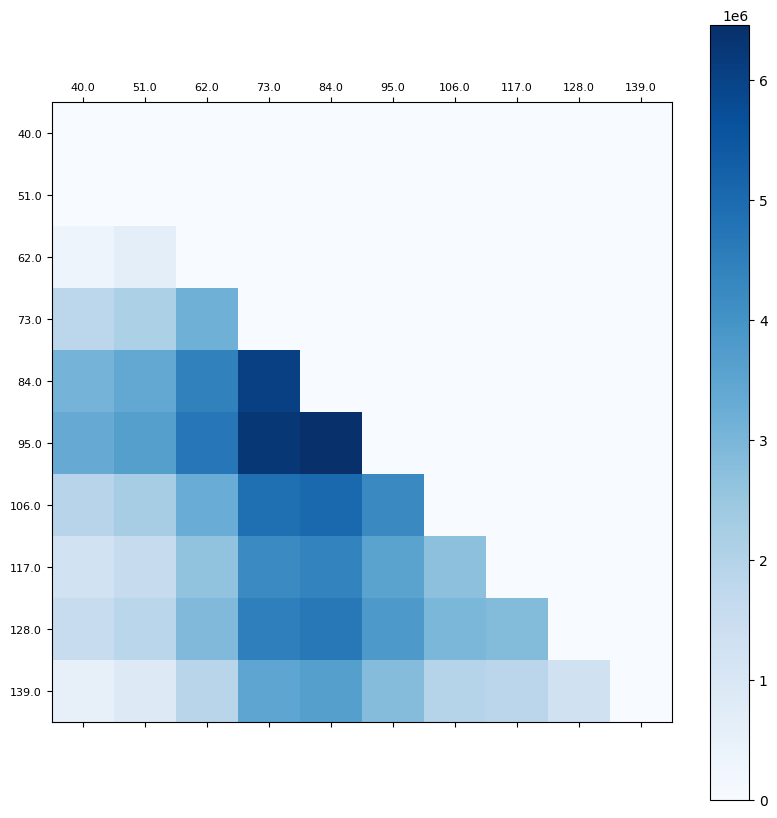

In [190]:
plt.figure(figsize=(10, 10))


plt.matshow(matrix_probability, cmap=plt.cm.Blues, fignum=1)


plt.xticks(
    range(len(second_returns_bin_edges) - 1),
    second_returns_bin_edges[:bins],
    fontsize=8,
)


plt.yticks(
    range(len(second_returns_bin_edges) - 1),
    second_returns_bin_edges[:bins],
    fontsize=8,
)


plt.colorbar()
# plt.gca().yaxis.set_major_formatter(FormatStrFormatter('{x:,.2f}')) # 2 decimal places
# plt.gca().xaxis.set_major_formatter(FormatStrFormatter('{x:,.2f}')) # 2 decimal places


plt.show()